In [156]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [157]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [158]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [159]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [160]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [161]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

# a = get_discount_matrix(10, rev=True, cor_supr_size=2)
# a = np.array(a, dtype='float')
# # a[:, 0:2] = 0
# print(a)
# show_image(a, cmap='Greys')

In [162]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [163]:
def relax(I: ndarray,
          inp_S: ndarray,
          W: ndarray,
          inp_NS: ndarray,
          NW: ndarray,
          inp_PS: ndarray,
          inp_NPS: ndarray,
          iter_cnt=100,
          ddsc=1.0,
          s_axis = 0,
          eps0 = 0.01,
          S_C: Literal['eps', 'R', None] = None,
          ):
    S = np.copy(inp_S)
    NS = np.copy(inp_NS)
    O = np.zeros(S.shape[0])

    prev_S = np.copy(inp_S)
    prev_NS = np.copy(inp_NS)
    prev_O = np.copy(O)
    prev_SO = np.zeros(S.shape)
    prev_NSO = np.zeros(NS.shape)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    is_break = False

    eq_cp_cnt = 0

    delta_O = np.zeros(O.size)

    for iter_idx in range(iter_cnt):
        eps = (iter_cnt - iter_idx) * eps0

        n = 1

        # infer
        np.fill_diagonal(S, 0)
        SO = I * S
        DO = np.exp((SO - W)**2 * -20.0)
        DO *= inp_PS
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        # dO **= n
        # dO /= np.max(dO)
        # O += dO

        # inhibition infer
        np.fill_diagonal(NS, 0)
        NSO = I * NS
        NDO = np.exp((NSO - NW)**2 * -20.0)
        NDO *= inp_NPS
        np.fill_diagonal(NDO, 0)
        dNO = np.sum(NDO, axis=1)
        # dNO **= n
        # dNO /= np.max(dNO)
        # O -= dNO

        # infer iter update
        adO = (dO - dNO)
        # sgn_adO = np.sign(adO)
        # adO **= n
        # adO = sgn_adO * np.abs(adO)
        
        Q0 = 0
        
        Q1 = 0.5
        Q2 = 4
        # adO = (Q2 / (1 + np.exp(-(Q0 + Q1 * adO)))) - (Q2 * 0.5)

        # adO /= np.max(np.abs(adO))
        # O += adO
        # adO *= eps
        # O += np.sign(adO) * (adO ** n)
        delta_O += adO
        print(f'{delta_O.max()=} {delta_O.min()=}')

        O = (Q2 / (1 + np.exp(-(Q0 + Q1 * delta_O)))) - (Q2 * 0.5)

        # inhibition
        O[np.where(O < 0)] = 0

        # threshold
        # thre = 0.5
        # O[np.where(O > thre)] = thre

        # train inh stats S
        R = (np.random.rand(S.shape[0], S.shape[1]) * eps0)
        O = O / np.max(O)
        if S_C == 'R':
            ddS = O * I[np.newaxis].T * R
        if S_C == 'eps':
            ddS = O * I[np.newaxis].T * eps
        else:
            ddS = O * I[np.newaxis].T

        # inh update
        NS += ddS

        # update
        S += ddS

        # stats
        mask_O = (O > 0)[np.newaxis].T
        SP.append(np.sum(O))
        MP.append(np.mean(O[np.where(O > 0)]))
        CP.append(np.sum(O > 0))
        DP.append(np.mean(np.abs(SO - W) * mask_O) + np.mean(np.abs(NSO - NW) * mask_O))

        # recur
        # O /= np.max(O)

        I = np.copy(O)

        max_S = np.max(S, axis=s_axis)
        if np.max(max_S) > 1:
            # print(f'{np.max(max_S)=}')
            if s_axis == 1:
                S /= max_S[np.newaxis].T
            else:
                S /= max_S
            # print(f'{np.max(S)=}')

        max_NS = np.max(NS, axis=s_axis)
        if np.max(max_NS) > 1:
            # print(f'{np.max(max_NS)=}')
            if s_axis == 1:
                NS /= max_NS[np.newaxis].T
            else:
                NS /= max_NS

        # prev
        if not is_break:
            prev_S = np.copy(S)
            prev_NS = np.copy(NS)
            prev_O = np.copy(O)
            prev_SO = np.copy(SO)
            prev_NSO = np.copy(NSO)

        # stats
        OST.append(np.copy(O))

        # break
        if iter_idx > 1 and MP[iter_idx-1] > MP[iter_idx] and MP[iter_idx-1] > MP[iter_idx - 2]:
            # break
            depth = (MP[iter_idx-1] - MP[iter_idx]) + (MP[iter_idx-1] - MP[iter_idx - 2])
            # print(f'Mean Out break: {iter_idx-1=} {depth=}')
            # break
        
        if iter_idx > 1 and DP[iter_idx-1] < DP[iter_idx] and DP[iter_idx-1] < DP[iter_idx - 2]:
            depth = (DP[iter_idx] - DP[iter_idx-1]) + (DP[iter_idx - 2] - DP[iter_idx-1])
            print(f'Err break: {iter_idx-1=} {depth=} {DP[iter_idx-1]=} {CP[iter_idx-1]=}')
            # break
            # is_break = True
        
        if iter_idx > 1 and CP[iter_idx-1] == CP[iter_idx]:
            eq_cp_cnt += 1
        else:
            eq_cp_cnt = 0
        
        eq_cp = 10
        if eq_cp_cnt == eq_cp:
            print(f'CP break: {iter_idx=} {CP[iter_idx]=}')
            # break
            # is_break = True

    return prev_S, prev_NS, prev_O, prev_SO, prev_NSO, SP, MP, CP, DP, OST


In [164]:
a = np.array([[1,2,3,4],[5,6,7,8],[1,2,3,4],[5,6,7,8]])
b = np.array([0,1,0,2])
a *= b[np.newaxis].T
a *= b
a
b[np.bitwise_and(b > 0, b > 1, b > 2)]

array([2])

In [165]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)

s_c = 0.01
S = np.random.rand(O.size, I.size) * s_c
NS = np.random.rand(O.size, I.size) * s_c

ps_c = 0.01
PS = np.random.rand(O.size, I.size) * ps_c
NPS = np.random.rand(O.size, I.size) * ps_c

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')

thre_S = 0.05

iter_cnt = 100 * 1

epoch_cnt = 1

eps0 = 0.0001
# eps = eps0

DP = []
CP = []
SP = []
MP = []

images_idx = [10, 0]

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    img_O = []

    for img_idx in images_idx:
        img = images[img_idx]

        I = np.copy(img)
        print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

        prev_S, prev_NS, O, SO, NSO, rlx_SP, rlx_MP, rlx_CP, rlx_DP, OST = relax(I=I,
                                                                                 inp_S=S,
                                                                                 W=W,
                                                                                 inp_NS=NS,
                                                                                 NW=NW,
                                                                                 inp_PS=PS,
                                                                                 inp_NPS=NPS,
                                                                                 iter_cnt=100 * 1,
                                                                                 ddsc=1.0,
                                                                                 s_axis=0,
                                                                                 S_C=None,
                                                                                 eps0=0.01,)

        threshold = np.mean(O)

        mask_O = (O > 0)[np.newaxis].T
        img_O.append(O)

        # stats train
        ddS = O * I[np.newaxis].T * eps

        excit_mask = (O > threshold)

        # S train
        dS = np.copy(ddS)
        dS *= excit_mask[np.newaxis].T
        dS *= excit_mask

        # train
        dW = (SO - W) * eps
        dW *= excit_mask[np.newaxis].T
        dW *= excit_mask

        # update
        W += dW
        # S += dS
        PS += dS

        inh_mask = (O <= threshold)

        # inh S train
        dNS = np.copy(ddS)
        dNS *= inh_mask[np.newaxis].T
        dNS *= excit_mask

        # inh train
        dNW = (NSO - NW) * eps
        dNW *= inh_mask[np.newaxis].T
        dNW *= excit_mask

        # inh update
        NW += dNW
        # NS += dNS
        NPS += dNS

        # stats
        if img_idx == 0:
            DP.extend(rlx_DP)
            CP.extend(rlx_CP)
            SP.extend(rlx_SP)
            MP.extend(rlx_MP)
        
        # recur dendritic S
        max_PS = np.max(PS, axis=1)
        if np.max(max_PS) > 1:
            PS /= max_PS[np.newaxis].T

        max_NPS = np.max(NPS, axis=1)
        if np.max(max_NPS) > 1:
            NPS /= max_NPS[np.newaxis].T
        
        # show_image(image=OST[-1].reshape(img_side, img_side))

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')
print(f'{PS.shape=} {PS.max()=} {PS.min()=} {np.median(PS)=}')


W (784, 784) 0.9999997857553273 1.376892500015714e-08 0.5010537810739861
S.shape=(784, 784) S.max()=0.009999986785273779 S.min()=2.6320311874439286e-09 np.median(S)=0.004998301517593966
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
delta_O.max()=0.23480804826263735 delta_O.min()=-0.2721383673022778
delta_O.max()=0.4714250101841776 delta_O.min()=-0.5462428326649458
delta_O.max()=0.7122194725447004 delta_O.min()=-0.8204532931871724
delta_O.max()=0.9542856852006604 delta_O.min()=-1.094517312251651
delta_O.max()=1.250990476237794 delta_O.min()=-1.368184059578198
delta_O.max()=1.5482019786830306 delta_O.min()=-1.6413434768765787
delta_O.max()=1.8431750195483558 delta_O.min()=-1.914248089359654
delta_O.max()=2.134350415597326 delta_O.min()=-2.187009285943577
delta_O.max()=2.4243787391742297 delta_O.min()=-2.459642963725604
delta_O.max()=2.713978527957158 delta_O.min()=-2.7321571428116025
delta_O.max()=3.0019817021638606 delta_O.min()=-3.00456315881116
Err break: iter_idx-1=9 depth=

CP[-1]=376


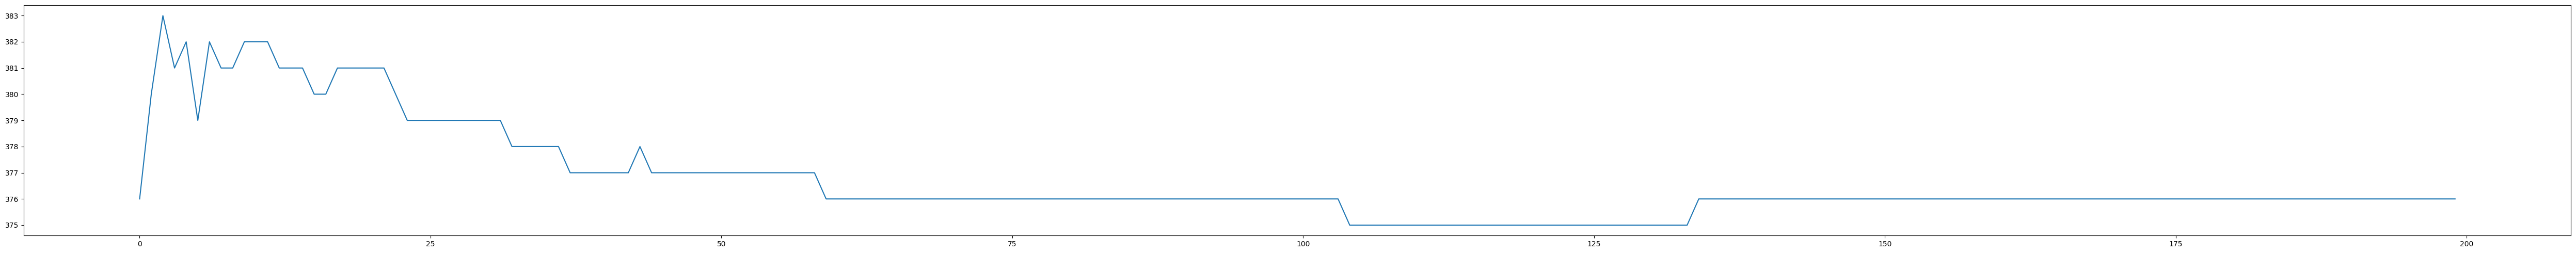

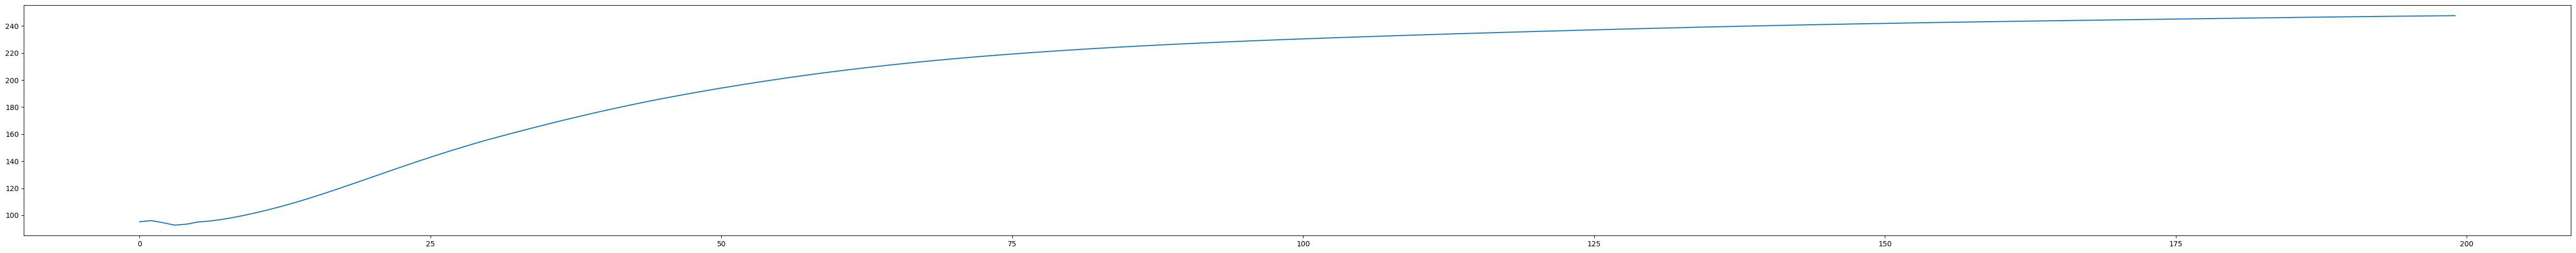

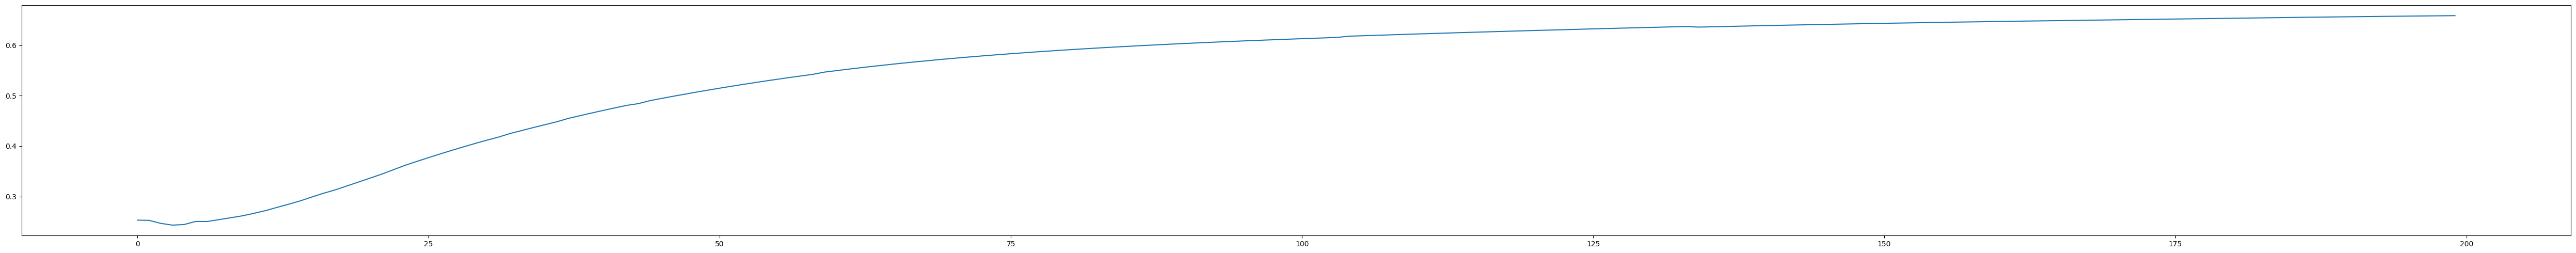

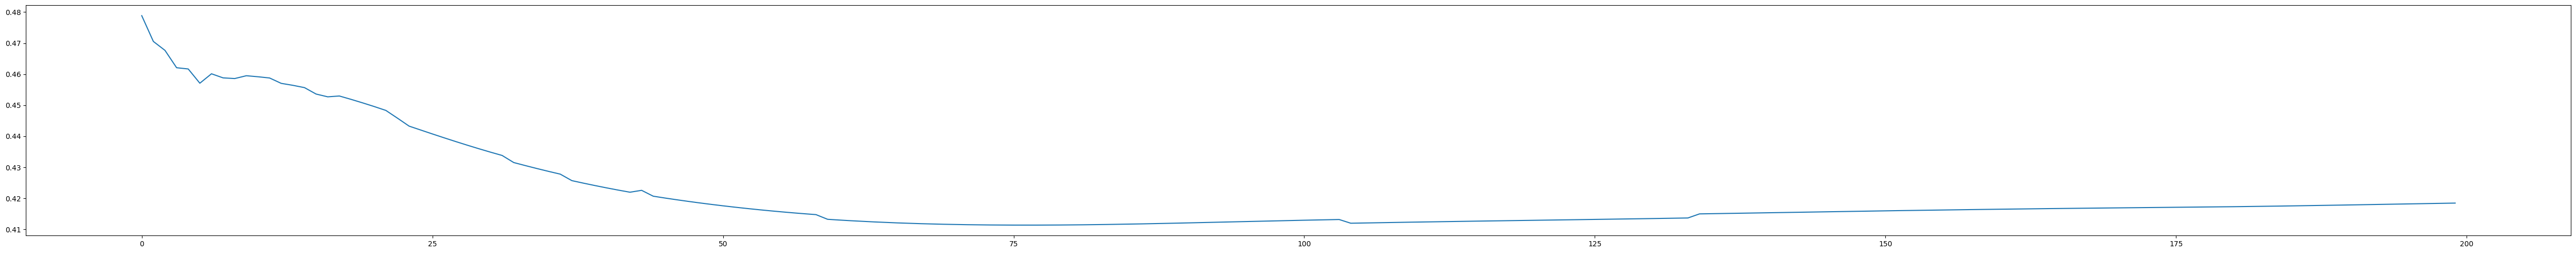

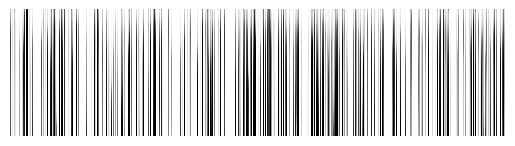

In [166]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

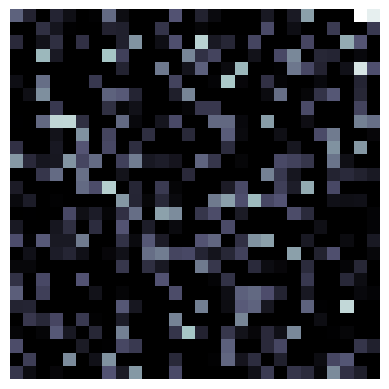

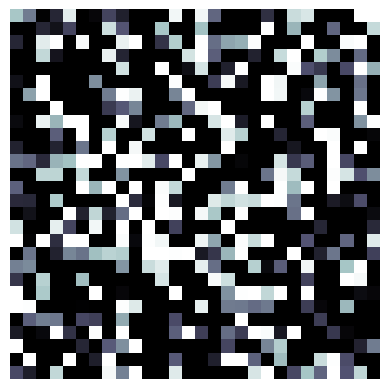

In [167]:
show_image(image=OST[0].reshape(img_side, img_side))
show_image(image=OST[-1].reshape(img_side, img_side))